# Leven at Newby Bridge using HBV model in eWaterCycle
This notebook demonstrates how eWaterCycle is used to run a model, in this case the classic HBV model.

For this example, we chose a catchment in the Lake District in the UK. River discharge in river Leven is measured at the weirs at Newby Bridge, see the photo below. This observational data is available through the CamelsGB dataset [(Coxon, 2020)](https://essd.copernicus.org/articles/12/2459/2020/).
The larger [Caravan](https://www.nature.com/articles/s41597-023-01975-w) (collection of Camels...) dataset is available through eWaterCycle and will be used below.

![image](https://upload.wikimedia.org/wikipedia/commons/7/76/Weirs_on_the_River_Leven_at_Newby_Bridge_-_geograph.org.uk_-_5455774.jpg)

*Weirs on the River Leven at Newby Bridge by G Laird*

As a model we choose the classic [HBV model](https://hess.copernicus.org/articles/26/1371/2022/) for its simplicity. This nicely demonstrates how eWaterCycle works. More complex models are available through eWaterCycle, however:

- these often require parameter sets specific to a region
- these are more computationally intensive to run and therefore unsuited for a short 45 minute workshop.

Ask us about available models if you want to collaborate! 

### HBV model structure

The stucture of the HBV model is shown below.
Do note that the figure is missing a snow reservoir, however this has been implemented in the HBV model in this notebook.

![image](_images/model_layout.png)

*Image from the TU Delft course ENVM1502 - "River Basin Hydrology" by Markus Hrachowitz* 


## Starting up
To start up, we need to import eWaterCycle and a number of general Python libraries. 'Under the hood' eWaterCycle depends on a large number of other pieces of software, including but not limited to

- [grpc4bmi](https://github.com/eWaterCycle/grpc4bmi), a 'translator' for BMI function calls between different programming languages and across containers. This library was build by the eWaterCycle team, but is available openly for anyone that can benefit from its functionality. 
- apptainer, a container engine that runs the model-containers (Docker is supported too).
- [ESMValTool](https://github.com/ESMValGroup/ESMValTool), a climate data processing toolbox that originally intended to post-process climate data from CMIP projects for inclusion in IPCC reports, we adopted as tool for pre-processing climate data into forcing data for hydrological models
- Numerous hydrological models that are made available as plugins to eWaterCycle, see [eWaterCycle-leakybucket](https://github.com/eWaterCycle/ewatercycle-leakybucket) as an example. Note that plugins do not have to be owned and maintained by the eWaterCycle team: anyone with a model can make a plugin for eWaterCycle and make their model be available for others through the platform. 

Furthermore, eWaterCycle requires forcing data, obsrvational data and parameter sets to be available to users. If you want to install eWaterCycle on your own infrastructure, see the [eWaterCycle documentation](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) or contact us.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

In [2]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Choose region and time period: 
The HBV model is a lumped hydrological model. It considers a catchment as a homogenious area and calculates the major hydrological processes in it. It requires spatially aggregated rainfall and potential evaporation as inputs (ie. forcings). To calculate its modelled discharge at the outlet of the catchment it also needs a set of parameters. Usually these paramters are calibrated using (historical) observational data, so this is also required. 

in eWaterCycle we provide access to the Caravan dataset, which contains all of the above data for all the catchments in the different Camels datasets. However, for two reasons, we don't use the rainfall and potential evaporation data from Caravan

1. This allows us to demonstrate how to generate forcing data for any model from ERA5 (working on ERA5Land) and from CMIP data
2. There is a known problem with the caravan evaporation data and we want to avoid using it here.

We thus only use the Caravan dataset to retreive 

- a shapefile of the region of interest, to be used as input for generating the forcing from ERA5
- the observational data of river discharge

Using the interactive maps at [eWaterCycle caravan map](https://www.ewatercycle.org/caravan-map/) one can easily retrieve the identifier of the catchment.

Note that changing the region below will work, but that the parameters that are loaded later in this notebook are calibrated specifically for this catchment!

In [3]:
camelsgb_id = "camelsgb_73010"

We have to specify start and end date of the experiment that we want to do. For now we don't fuzz with diverences between calibration and validation periods (which officially of course is very bad...)

In [4]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

## Set up paths

Since forcing files are often re-used between experiments it is a best practice to save those intermediate files for re-use between experiments. These logical save-points in workflows are called 'rustpunten' in Dutch. It is important to store data in 'rustpunten' in standard formats. Working with clearly defined 'rustpunten' is a key element in the design of good workflows in general and was instrumental in designing eWaterCycle in particular. 

Here we set up some paths to store the forcing files we generate in your own home directory. 

To speed up this workshop, we have already created the forcing files in a central location, which we also create pointers to here. If you want to run for a different region, you will have to generate the forcing yourself. 

In [5]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

# Location where the ERA5 forcing generated for your catchment of choice will be stored
forcing_path_ERA5 = Path.home() / "forcing" / camelsgb_id / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_ERA5_central = Path("location/of/forcing/data")

## Generate or load forcing
There are three options for creating forcing data objects:

- generate from climate data such as ERA5 or CMIP. Note that if the directory you specify as destination already contains data this trying this will throw an error!
- load forcing data you generated previously by providing the location where it was stored
- load forcing data someone else (such as your teacher or a workshop leader) generated previously by providing the location where it was stored

First we will create a caravan forcing object, but as mentioned above, we will only use this for the discharge observations and the shape file of the region. After generating the object we show the fields it contains and plot the discharge data. 

The actual forcing object we will use in this example is the ERA5 based data.

For both caravan and ERA5 based forcing, only one of the options provided below should be used, use comments to select which one you want to use.

In [6]:
# option one: generate forcing data
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    directory=forcing_path_caravan,
    basin_id=camelsgb_id,
)

In [7]:
# # option two or three: load data that you or someone else generated previously
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory=prepared_forcing_path_caravan_central)

In [8]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan'),
    shape=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc'
    }
)

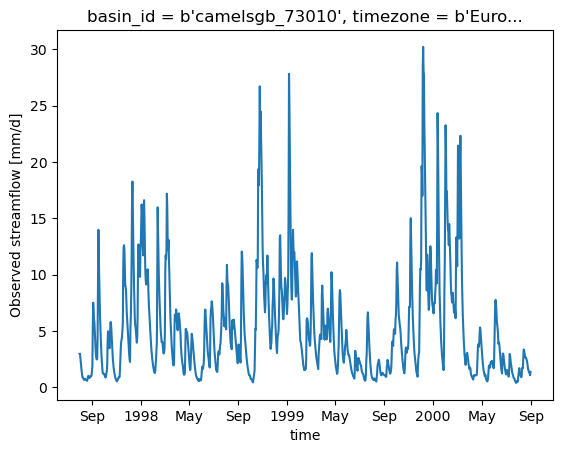

In [9]:
#quick plot of the discharge data. 
ds_forcing = xr.open_dataset(camelsgb_forcing['Q'])
ds_forcing["Q"].plot()

Below we generate forcing from ERA5. Note that ERA5 data needs to be stored on the system you are working on. For SURF Research Cloud machines running the eWaterCycle catalog item, this is handled by the eWaterCycle team. 

In [10]:
# option one: generate forcing:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset="ERA5",
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=camelsgb_forcing.shape,
)

# # option two: load data that you or someone else generated previously
# #   this is needed because ERA5 forcing data is stored deep in a sub-directory
# load_location = prepared_forcing_path_ERA5_central / "work" / "diagnostic" / "script" 
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [11]:
print(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/ewatercycle-hbv/docs/esmvaltool_output/ewcreput10t2cx_20250218_133735/wor
k/diagnostic/script'),
    shape=PosixPath('/home/rhut/forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1997-2000.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1997-2000.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1997-2000.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

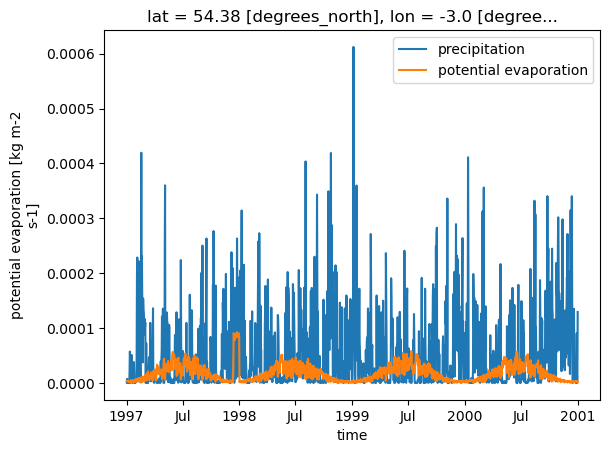

In [14]:
#quick plot of the precipitation and potential evaporation data
ds_ERA5 = xr.open_mfdataset([ERA5_forcing['pr'],ERA5_forcing['evspsblpot']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## Load parameters from calibration

The HBV model contains five "stores" where the water is stored and nine parameters that control the flow between those stores and in and out of the model.
We have already calibrated the model for our region of choice and hardcoded those below. If you have changed the region and have calibrated for your region, you need to point to your calibration results here by uncommenting the load statement and pointing to the right file.

In [16]:
# load pre-calibrated constants. If you have calibrated for a different region, comment this part and 
# uncomment the load statement below
par_0 = [7.085, 0.837, 76.373, 1.112, 0.245, 7.801, 0.096, 0.003, 0.226];

# #load calibration constants from a csv file
# par_0 = np.loadtxt("your/calibration/file.csv", delimiter = ",")

In [17]:


param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 7.085),
    ('Ce', 0.837),
    ('Sumax', 76.373),
    ('Beta', 1.112),
    ('Pmax', 0.245),
    ('Tlag', 7.801),
    ('Kf', 0.096),
    ('Ks', 0.003),
    ('FM', 0.226)
]

For the storages we can specify an array of starting values. If you don't the model will start 'empty' and needs some timesteps to 'fill up'. Especially for the rootzone storage it helps to not start empty. Note that all units are in mm: <br>

In [18]:
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

## Setting up the model
Below we show the core use of eWaterCycle: to users models are objects. We stay as close as possible to the standard BMI functions, but make sure that under the hood eWaterCycle makes everything run. Getting a model to run requires three steps:

1. creating a model object, an instance of the specific model class. This is provided by the different plugins. At the point of creation, the forcing object that will be used need to be passed to the model:

In [19]:
model = ewatercycle.models.HBV(forcing=ERA5_forcing)

2. creating a configuration file that contains all the information the model needs to initialize itself.
   The format of the configuration file is very model specific. For example, the HBV configuration file contains information on:
  - the location of forcing files
  - the values of parameters and initial storages

In [20]:
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)

3. initializing starts the model container, creates all variables, and basically gets the model primed to start running.

In [21]:
model.initialize(config_file)

## Running the model
The basic loop that runs the model calls the ```model.update()``` to have the model progress one timestep and ```model.get_value()``` to extract information of interest. More complex experiment can interact with the model using, for example, ```model.set_value()``` to change values. In this way 

- multiple models can interact (including be coupled)
- models can be adjusted during runtime to incoming observations (ie. data assimilation)
- Effects not covered by the model can be calculated seperatly and included to create 'what if' experiments.
- and many more applications.

In [22]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

After running the model we need to call ```model.finalize()``` to shut everything down, including the container. If we don't do this, the container will continue to be active, eating up system memory.

In [23]:
model.finalize()

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [24]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

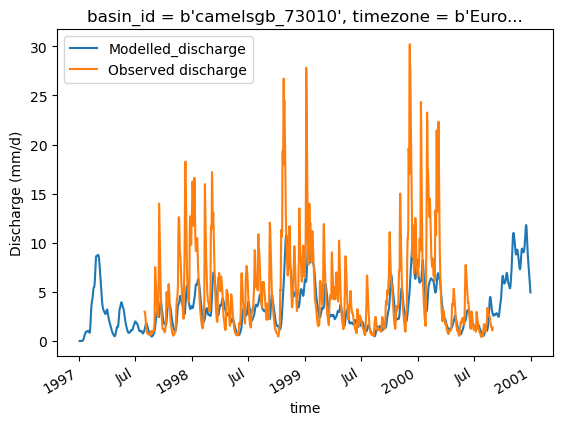

In [25]:
model_output.plot()
ds_forcing["Q"].plot(label="Observed discharge")
plt.legend()
plt.ylabel("Discharge (mm/d)")

In [26]:
#we want to also be able to use the output of this model run in different analyses. Therefore we save it as a NetCDF file
xr_model_output = model_output.to_xarray()

xr_model_output.attrs['units'] = 'mm/d'

# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf('~/river_discharge_data.nc')